In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.onnx 
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
from pathlib import Path
import numpy as np

In [2]:
df = pd.read_json('../data/data.json')

In [3]:
df_shape = df.shape
print(f'Rows and columns in one JSON file is {df_shape}')

Rows and columns in one JSON file is (132, 6)


In [4]:
df_rows = df.head(10)
print(f'First 10 columns in one JSON file is {df_rows}')

First 10 columns in one JSON file is                    name artist  year gender   likes  bought
0                 Queen  Queen  1973   Rock  3258.0    True
1              Queen II  Queen  1974   Rock  4017.0    True
2    Sheer Heart Attack  Queen  1974   Rock  2427.0    True
3  A Night at the Opera  Queen  1975   Rock  2712.0   False
4     News of the World  Queen  1977   Rock  3488.0    True
5                  Jazz  Queen  1978   Rock  1377.0    True
6              The Game  Queen  1980   Rock  6636.0    True
7             Hot Space  Queen  1982   Rock  1762.0    True
8             The Works  Queen  1984   Rock  5530.0    True
9       A Kind of Magic  Queen  1986   Rock  3328.0    True


In [5]:
print(f'The column names are :')
print('#########')
for col in df.columns:
    print(col)

The column names are :
#########
name
artist
year
gender
likes
bought


In [6]:
cols = df.filter(regex='nam').columns

print(cols)

Index(['name'], dtype='object')


In [7]:
print("The #rows and #columns are ", df.shape[0] , " and ", df.shape[1])
print("The years in this dataset are: ", df.year.unique())
print("The artists covered in this dataset are: ", list(df.artist.unique()))
print("The genders covered are: ", list(df.gender.unique()))

The #rows and #columns are  132  and  6
The years in this dataset are:  [1973 1974 1975 1977 1978 1980 1982 1984 1986 1989 1991 1995 1993 1963
 1964 1965 1966 1967 1968 1970 1976 1979 1981 2021 2012 2015 2017 2018
 1999 2001 2003 2006 2009 2022 1969 1971 1972 1983 1987 1997 2002 2013
 2016 1996 2000 2010 2014 2004 2005 2008 2019 2020 2024]
The artists covered in this dataset are:  ['Queen', 'Nirvana', 'The Beatles', 'ABBA', 'Imagine Dragons', 'MUSE', 'Rosalía', 'David Bowie', 'Spice Girls', 'Michael Jackson', 'Archive', 'Daft Punk', 'Taylor Swift']
The genders covered are:  ['Rock', 'Pop', 'Pop Rock', 'Alternative Rock', 'Flamenco', 'Electronic']


In [8]:
dict = {'Rock': 0, 'Pop': 1, 'Pop Rock': 2, 'Alternative Rock': 3, 'Flamenco': 4, 'Electronic': 5}
df['gender'] = df['gender'].map(dict)

In [9]:
counts = pd.DataFrame({'Count':df.gender.value_counts()})
counts

,Count
gender,
0,64
1,36
5,16
3,9
2,4
4,3


In [10]:
counts.sort_values(by=['gender'],ascending=True).head(15)

,Count
gender,
0,64
1,36
2,4
3,9
4,3
5,16


In [11]:
df.rename(columns={'bought':'is_bought'}, inplace=True)

In [12]:
df.isnull().sum(axis=0)

name         0
artist       0
year         0
gender       0
likes        2
is_bought    0
dtype: int64

In [13]:
df = df[~df.likes.isnull()]
df.isnull().sum(axis = 0)

name         0
artist       0
year         0
gender       0
likes        0
is_bought    0
dtype: int64

<Axes: xlabel='is_bought', ylabel='count'>

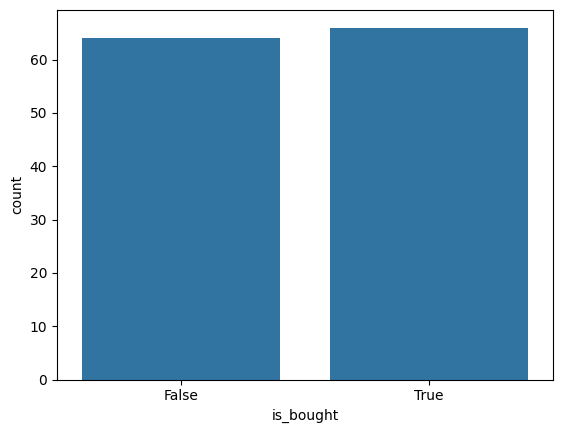

In [14]:
sns.countplot(x = 'is_bought', data=df)

In [15]:
data_orig = df.copy()
data = df[['is_bought', 'likes','name', 'artist', 'year', 'gender']]
categorical_columns  = ['name', 'artist', 'year']
for c in categorical_columns:
    data[c] = data[c].astype('category')
    
print(f'The column names are :')
print('#########')
for col in data.columns:
    print(col)

print(f'The column types are :')
print('#########')
for col in data.dtypes:
    print(col)

The column names are :
#########
is_bought
likes
name
artist
year
gender
The column types are :
#########
bool
float64
category
category
category
int64


In [16]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)
data_dummies = data_dummies.replace({True: 1, False: 0})
not_categorical_columns  = ['is_bought','gender']
data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns,axis=1, inplace=True)

C:\Users\j.pardo\AppData\Local\Temp\ipykernel_68\1784471954.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_dummies = data_dummies.replace({True: 1, False: 0})


In [17]:
print("The #rows and #columns are ", data.shape[0] , " and ", data.shape[1])

The #rows and #columns are  130  and  193


In [18]:
print(f'The column names are :')
print('#########')
for col in data.columns:
    print(col)

The column names are :
#########
is_bought
likes
gender
name_1989
name_A Hard Day's Night
name_A Kind of Magic
name_A Night at the Opera
name_ABBA
name_Abbey Road
name_Absolution
name_Aladdin Sane
name_Arrival
name_Axiom
name_Bad
name_Beatles '65
name_Beatles VI
name_Beatles for Sale
name_Ben
name_Black Holes and Revelations
name_Black Tie White Noise
name_Bleach
name_Blood on the Dance Floor: History in the Mix
name_Call to Arms and Angels
name_Controlling Crowds
name_Controlling Crowds – Part IV
name_Dangerous
name_Diamond Dogs
name_Discovery
name_Drones
name_Earthlinge
name_El mal querer
name_Evermore
name_Fearless
name_Folklore
name_Forever
name_Forever, Michael
name_Got to Be There
name_Heathen
name_Help!
name_History: Past, Present and Future, Book I
name_Homework
name_Hot Space
name_Hours...
name_Human After All
name_Hunky Dory
name_In Utero
name_Innuendo
name_Introducing... The Beatles
name_Invincible
name_Jazz
name_Let It Be
name_Let's Dance
name_Lights 
name_Lodger
name_Londi

In [19]:
data.rename(columns = {'is_bought':'target'}, inplace=True )

In [20]:
features = ['gender']

In [21]:
X = data[features]
Y = data['target']

Train / Test Data

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

Config

In [23]:
batch_size = 10
num_of_epochs = 1000
learning_rate=0.01
weight_decay=0.0001

Tensors

In [24]:
class Data(Dataset):
  def __init__(self, X: np.ndarray, y: np.ndarray) -> None:  
    self.X = torch.from_numpy(X.astype(np.float32))
    self.y = torch.from_numpy(y.astype(np.float32))
    self.len = self.X.shape[0]

  def __getitem__(self, index: int) -> tuple:
    return self.X[index], self.y[index]
  
  def __len__(self) -> int:
    return self.len

Train / Test Data Batches

In [25]:
traindata = Data(x_train.values, y_train.values)
testdata = Data(x_test.values, y_test.values)

trainloader = DataLoader(traindata, batch_size=batch_size, shuffle=True)

testloader = DataLoader(testdata, batch_size=batch_size, shuffle=True)

Model Architecture:

In [26]:
class LinearRegression(nn.Module): # all the dependencies from torch will be given to this class [parent class] # nn.Module contains all the building block of neural networks:
  def __init__(self,input_dim):
    super(LinearRegression,self).__init__()   # building connection with parent and child classes
    self.fc1=nn.Linear(input_dim,10)          # hidden layer 1
    self.fc2=nn.Linear(10,5)                  # hidden layer 2
    self.fc3=nn.Linear(5,3)                   # hidden layer 3
    self.fc4=nn.Linear(3,1)                   # last layer

  def forward(self,d):
    out=torch.relu(self.fc1(d))              # input * weights + bias for layer 1
    out=torch.relu(self.fc2(out))            # input * weights + bias for layer 2
    out=torch.relu(self.fc3(out))            # input * weights + bias for layer 3
    out=self.fc4(out)                        # input * weights + bias for last layer
    return out                               # final outcome

Model setup:

In [27]:
input_dim = x_train.shape[1]
torch.manual_seed(42)  # to make initilized weights stable:
model = LinearRegression(input_dim)

Loss & Optimizer

In [28]:
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss = nn.CrossEntropyLoss()
optimizers=optim.Adam(params=model.parameters(),lr=learning_rate, weight_decay = weight_decay)

Using TensorBoard

In [29]:
writer = SummaryWriter()

In [30]:
def save() -> None:
    filename=Path('saved')
    filename.mkdir(parents=True,exist_ok=True)    
    model_name='linear_regression.pth' 

    saving_path=filename/model_name   
    torch.save(obj=model.state_dict(),f=saving_path)

In [31]:
# Function to test the model with the test dataset and print the accuracy for the test images
def test() -> None:
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in testloader:
            inputs, targets = data
            # run the model on the test set to predict labels
            outputs = model(inputs)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            accuracy += (predicted == targets).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

In [32]:
def train(num_of_epochs) -> None:

  best_accuracy = 0.0


  # Define your execution device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("The model will be running on", device, "device")

  model.to(device)

  # loop over the dataset multiple times
  for epoch in range(num_of_epochs):

    running_loss = 0.0
       
    for i, data in enumerate(trainloader, 0):  
       # get the inputs
      inputs, targets = data
      inputs, targets = inputs.float(), targets.float()
      targets = targets.reshape((targets.shape[0], 1))


      # zero the parameter gradients
      optimizers.zero_grad()
      # predict classes using records from the training set
      outputs=model(inputs) 
      # compute the loss based on model output and real targets
      loss_value=loss(outputs, targets) 
      # backpropagate the loss
      loss_value.backward()  
      # adjust parameters based on the calculated gradients
      optimizers.step() 

      # Let's print statistics for every 10 records
      running_loss += loss_value.item()

      writer.add_scalar("Loss/train", loss_value, epoch)
     
      if i % num_of_epochs == 999:             
 
        # print every 1000 (twice per epoch) 
        print('[%d, %5d] loss: %.3f' % (epoch, i , running_loss / num_of_epochs))
        # zero the loss
        running_loss = 0.0      
     

      # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
      accuracy = test()
      print('For epoch', epoch,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
      if accuracy > best_accuracy:
          save()         
          best_accuracy = accuracy

Training

In [33]:
train(num_of_epochs)
print('Finished Training')

The model will be running on cpu device
For epoch 0 the test accuracy over the whole test set is 58 %
For epoch 0 the test accuracy over the whole test set is 58 %
For epoch 0 the test accuracy over the whole test set is 58 %
For epoch 0 the test accuracy over the whole test set is 58 %
For epoch 0 the test accuracy over the whole test set is 58 %
For epoch 0 the test accuracy over the whole test set is 58 %
For epoch 0 the test accuracy over the whole test set is 58 %
For epoch 0 the test accuracy over the whole test set is 58 %
For epoch 0 the test accuracy over the whole test set is 58 %
For epoch 1 the test accuracy over the whole test set is 58 %
For epoch 1 the test accuracy over the whole test set is 58 %
For epoch 1 the test accuracy over the whole test set is 58 %
For epoch 1 the test accuracy over the whole test set is 58 %
For epoch 1 the test accuracy over the whole test set is 58 %
For epoch 1 the test accuracy over the whole test set is 58 %
For epoch 1 the test accuracy 

In [34]:
# we can load the saved model and do the inference again 

load_model=LinearRegression(input_dim) # creating an instance again for loaded model
load_model.load_state_dict(torch.load('saved/linear_regression.pth'))

<All keys matched successfully>